In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# #QUAL GPU VOCÊ QUER USAR?
GPU_GLOBAL = 0


In [2]:
 import os
 os.chdir("drive/My Drive/visao-mestrado")

FileNotFoundError: [Errno 2] No such file or directory: 'drive/My Drive/visao-mestrado'

In [3]:
import tensorflow as tf


2024-01-15 14:04:44.729128: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
#configure gpu 
!conda install tensorflow-gpu




^C

CondaError: KeyboardInterrupt



In [6]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [7]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Substitua 0 pelo índice da GPU que deseja usar
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e:
        # Erro ao definir a GPU, geralmente devido a dispositivos já em uso
        print(e)

print(gpus)

[]


In [25]:

# PATH_IMAGENS_N = 'menshift-imagens/dataset/lamina/4_divisao_deixar_apenas_uma_imagem_por_campo_de_lamina_SEM_ERROS/Negativo/*.jpg'
# PATH_IMAGENS = 'menshift-imagens/dataset/lamina/4_divisao_deixar_apenas_uma_imagem_por_campo_de_lamina_SEM_ERROS/Positivo/*.jpg'


PATH_IMAGENS_N = 'dataset/meanshift/predictions/negativo/1/*sobreposto.png'
PATH_IMAGENS = 'dataset/meanshift/predictions/positivo/1/*sobreposto.png'


In [26]:
from skimage.io import imread_collection

leshimania = imread_collection(PATH_IMAGENS)
notleshimania = imread_collection(PATH_IMAGENS_N)

In [27]:
!ls menshift-imagens/

ls: cannot access 'menshift-imagens/': No such file or directory


In [29]:
len(leshimania)

20137

In [30]:
from skimage.transform import resize
import numpy as np
leshimania_resized = [np.array(resize(img,(224, 224))) for img in leshimania]
notleshimania_resized = [np.array(resize(img,(224, 224))) for img in notleshimania]


In [41]:
leshimania_resized = np.array(leshimania_resized)
notleshimania_resized = np.array(notleshimania_resized)

# leshimania_resized = np.array(leshimania)
# notleshimania_resized = np.array(notleshimania)

In [32]:
EPOCHS = 125
BATCH_SIZE = 8

In [33]:
from matplotlib import pyplot as plt
def funcaoPlot(imagens, title=None):
    fig, ax = plt.subplots(1, len(imagens), figsize=(60, 60))
    for i, folha in enumerate(imagens):
        ax[i].imshow(folha, cmap="gray")
        if title:
            ax[i].set_title(title[i])
        else:
            ax[i].set_title(str(i))

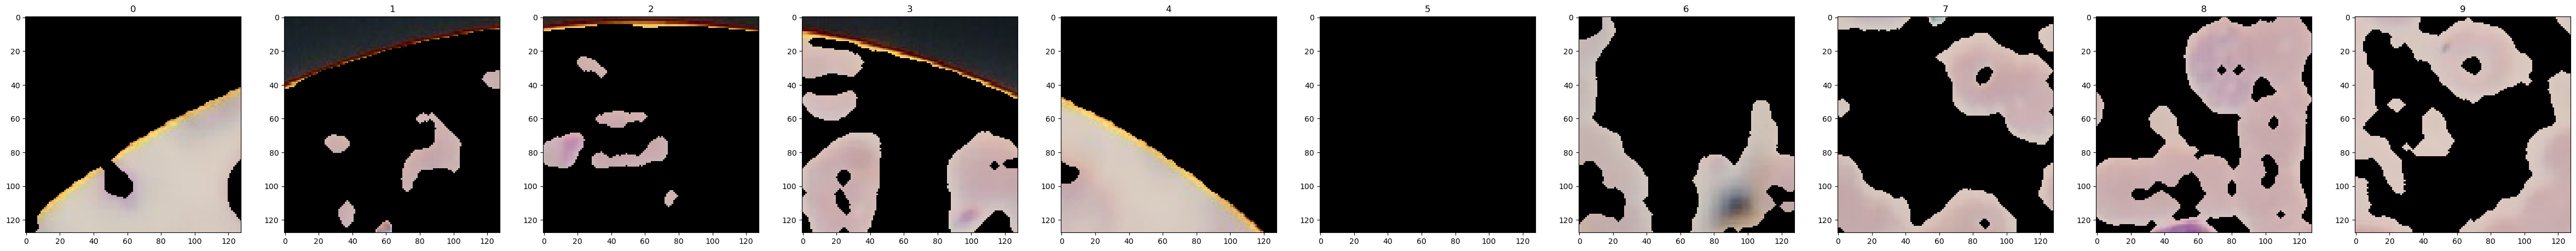

In [34]:
funcaoPlot(leshimania_resized[:10])

In [35]:
leshimania_label = np.ones(len(leshimania_resized))
notleshimania_label = np.zeros(len(notleshimania_resized))

In [36]:
from sklearn.model_selection import train_test_split

X_train_true, X_test_true, y_train_true, y_test_true = train_test_split(leshimania_resized, leshimania_label, test_size=0.7, random_state=40)
X_train_false, X_test_false, y_train_false, y_test_false = train_test_split(notleshimania_resized, notleshimania_label, test_size=0.7, random_state=40)

X_train = np.concatenate((X_train_true,X_train_false), axis=0)
X_test = np.concatenate((X_test_true,X_test_false), axis=0)
y_train = np.concatenate((y_train_true,y_train_false), axis=0)
y_test = np.concatenate((y_test_true,y_test_false), axis=0)

In [37]:
from keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator().flow(X_train, y_train, batch_size=BATCH_SIZE)
validation_generator = ImageDataGenerator().flow(X_test, y_test, batch_size=BATCH_SIZE)

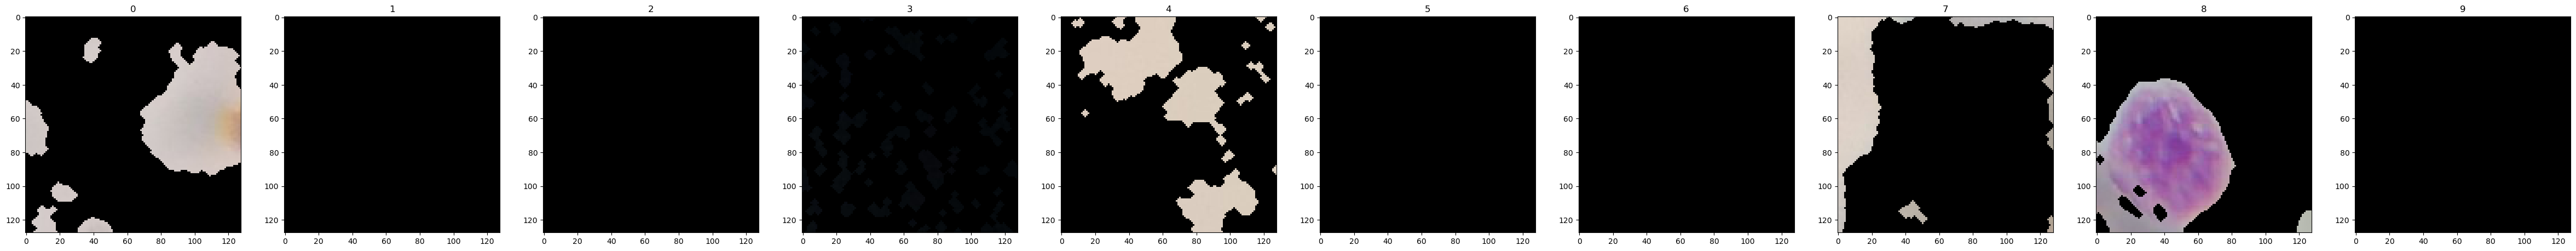

In [38]:
funcaoPlot(X_train[:10])

In [39]:
from keras.metrics import Precision, Recall, BinaryAccuracy
from keras import backend as K

# Função para calcular o F1-score
def f1_score(precision, recall):
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))


In [40]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, Flatten
from keras.optimizers import Adam

# Carregar a arquitetura VGG16 sem os pesos pré-treinados e sem as camadas superiores
base_model = VGG16(weights=None, include_top=False, input_shape=(224, 224, 3))

# Adicionar novas camadas para classificação
x = base_model.output
x = Flatten()(x)  # Achatar os outputs para um vetor
x = Dense(1024, activation='relu')(x)  # Adicionar uma camada densa
predictions = Dense(1, activation='sigmoid')(x)  # Camada de saída para classificação binária

# Construir o modelo final
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar o modelo
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy',
              metrics=[BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall')])

# Treinar o modelo
history = model.fit(train_generator,
                    steps_per_epoch=len(X_train) // BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=validation_generator,
                    validation_steps=len(X_test) // BATCH_SIZE)

model.save('vgg16_img_grande_125_epocas_batch_8_zero.h5')


# Plotar o gráfico de treinamento e validação
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

# Avaliar o modelo com o conjunto de teste
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(X_test, y_test)

# Calculando o F1-score
val_f1 = f1_score(val_precision, val_recall)

print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation Precision: {val_precision}")
print(f"Validation Recall: {val_recall}")
print(f"Validation F1-Score: {val_f1}")

2024-01-15 17:22:54.477535: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Epoch 1/125


2024-01-15 17:22:54.811109: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-01-15 17:22:56.103724: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: Matrix size-incompatible: In[0]: [8,8192], In[1]: [25088,1024]
	 [[{{node model/dense/Relu}}]]


InvalidArgumentError: Graph execution error:

Detected at node 'model/dense/Relu' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "/home/lucas/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/lucas/anaconda3/lib/python3.11/site-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/home/lucas/anaconda3/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 736, in start
      self.io_loop.start()
    File "/home/lucas/anaconda3/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/home/lucas/anaconda3/lib/python3.11/asyncio/base_events.py", line 607, in run_forever
      self._run_once()
    File "/home/lucas/anaconda3/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once
      handle._run()
    File "/home/lucas/anaconda3/lib/python3.11/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/lucas/anaconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "/home/lucas/anaconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "/home/lucas/anaconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell
      await result
    File "/home/lucas/anaconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "/home/lucas/anaconda3/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/home/lucas/anaconda3/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/lucas/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3024, in run_cell
      result = self._run_cell(
    File "/home/lucas/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3079, in _run_cell
      result = runner(coro)
    File "/home/lucas/anaconda3/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/lucas/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3284, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/lucas/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3466, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/lucas/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_3918/3795597613.py", line 23, in <module>
      history = model.fit(train_generator,
    File "/home/lucas/anaconda3/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/lucas/anaconda3/lib/python3.11/site-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/lucas/anaconda3/lib/python3.11/site-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/home/lucas/anaconda3/lib/python3.11/site-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/lucas/anaconda3/lib/python3.11/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/home/lucas/anaconda3/lib/python3.11/site-packages/keras/engine/training.py", line 1050, in train_step
      y_pred = self(x, training=True)
    File "/home/lucas/anaconda3/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/lucas/anaconda3/lib/python3.11/site-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/lucas/anaconda3/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/lucas/anaconda3/lib/python3.11/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/lucas/anaconda3/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/lucas/anaconda3/lib/python3.11/site-packages/keras/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/lucas/anaconda3/lib/python3.11/site-packages/keras/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/lucas/anaconda3/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/lucas/anaconda3/lib/python3.11/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/lucas/anaconda3/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/lucas/anaconda3/lib/python3.11/site-packages/keras/layers/core/dense.py", line 255, in call
      outputs = self.activation(outputs)
    File "/home/lucas/anaconda3/lib/python3.11/site-packages/keras/activations.py", line 317, in relu
      return backend.relu(
    File "/home/lucas/anaconda3/lib/python3.11/site-packages/keras/backend.py", line 5396, in relu
      x = tf.nn.relu(x)
Node: 'model/dense/Relu'
Matrix size-incompatible: In[0]: [8,8192], In[1]: [25088,1024]
	 [[{{node model/dense/Relu}}]] [Op:__inference_train_function_2222]

Tranferencia de apredizagem:

In [ ]:
from keras.applications import VGG16
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam


# Carregar a arquitetura VGG16 sem os pesos pré-treinados e sem as camadas superiores
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar as camadas da VGG16
for layer in base_model.layers:
    layer.trainable = False

# Adicionar novas camadas para classificação
x = base_model.output
x = Flatten()(x)  # Achatar os outputs para um vetor
x = Dense(1024, activation='relu')(x)  # Adicionar uma camada densa
predictions = Dense(1, activation='sigmoid')(x)  # Camada de saída para classificação binária


# Adicionar as camadas personalizadas sobre a base da VGG16
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # Nova camada FC e ReLU
predictions = Dense(1, activation='sigmoid')(x)  # Nova camada de saída para classificação binária

# Montar o modelo final
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy',
                  metrics=[BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall')]
)

# Treinar o modelo
history = model.fit(train_generator,
                    steps_per_epoch=len(X_train) // BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=validation_generator,
                    validation_steps=len(X_test) // BATCH_SIZE)

model.save('vgg16_img_grande_125_epocas_batch_8_tranfer.h5')

# Plotar o gráfico de treinamento e validação
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

# Avaliar o modelo com o conjunto de teste
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(X_test, y_test)

# Calculando o F1-score
val_f1 = f1_score(val_precision, val_recall)

print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation Precision: {val_precision}")
print(f"Validation Recall: {val_recall}")
print(f"Validation F1-Score: {val_f1}")

##Fine Tuning

In [ ]:
# Descongelar todas as camadas da VGG16 para fine-tuning
for layer in base_model.layers:
    layer.trainable = True

# Recompile o modelo com uma taxa de aprendizado menor
model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy',     metrics=[BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall')])


# Treinar o modelo
history = model.fit(train_generator,
                    steps_per_epoch=len(X_train) // BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=validation_generator,
                    validation_steps=len(X_test) // BATCH_SIZE)

model.save('vgg16_img_grande_125_epocas_batch_8_fine_turning.h5')

# Plotar o gráfico de treinamento e validação
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

# Avaliar o modelo com o conjunto de teste
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(X_test, y_test)

# Calculando o F1-score
val_f1 = f1_score(val_precision, val_recall)

print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation Precision: {val_precision}")
print(f"Validation Recall: {val_recall}")
print(f"Validation F1-Score: {val_f1}")

In [ ]:
from keras.metrics import BinaryAccuracy, Precision, Recall
from keras.callbacks import EarlyStopping, ModelCheckpoint
# Descongelar todas as camadas da VGG16 para fine-tuning
for layer in base_model.layers:
    layer.trainable = True

# Recompile o modelo com uma taxa de aprendizado menor
model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy',     metrics=[BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall')])


# Treinar o modelo
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
model_checkpoint = ModelCheckpoint(filepath='melhor_modelo_fine_tuning.h5', save_best_only=True, monitor='val_loss', mode='min')

# Adicionar os callbacks no método fit
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(X_test) // BATCH_SIZE,
    callbacks=[early_stopping, model_checkpoint]
)

model.save('vgg16_img_grande_125_epocas_batch_8_fine_turning.h5')

# Plotar o gráfico de treinamento e validação
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

# Avaliar o modelo com o conjunto de teste
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(X_test, y_test)

# Calculando o F1-score
val_f1 = f1_score(val_precision, val_recall)

print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation Precision: {val_precision}")
print(f"Validation Recall: {val_recall}")
print(f"Validation F1-Score: {val_f1}")